In [4]:
%load_ext rpy2.ipython

from cap2.capalyzer.pangea import PangeaFileSource
from cap2.capalyzer.pangea.utils import get_pangea_group

from plotnine import *
import pandas as pd
import warnings
from glob import glob
from os.path import isfile
from os import environ

warnings.filterwarnings('ignore')

twins_group = get_pangea_group('Mason Lab', 'NASA Twins', 'dcdanko@gmail.com', environ.get('PANGEA_PASS'))
twins_source = PangeaFileSource(twins_group)

filepaths = list(twins_source('cap2::experimental::make_snp_clusters', 'snp_clusters__Yersinia_canariae'))
iss_snps = pd.read_csv('nasa_iss.cap2::experimental::merge_snp_clusters.merged_snp_clusters__Yersinia_canariae.csv.gz', compression='gzip', index_col=0)
iss_snps['sample_name'] = 'ISS'


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [24]:
class SNPBarcode:

    def __init__(self, tbl):
        self.tbl = tbl.copy(deep=True)
        self.sample_name = tbl['sample_name'].unique()[0]
        self.seq = tbl['seq'].unique()[0]
        self.snps = set(zip(tbl['coord'], tbl['changed']))

    def __len__(self):
        return len(self.snps)


def barcode_barcode_similarity(b1, b2):
    if b1.seq != b2.seq:
        return 0
    jaccard = len(b1.snps & b2.snps) / len(b1.snps | b2.snps)
    return jaccard


def parse_snp_clusters(sample_name, filepath):
    tbl = pd.read_csv(filepath, compression='gzip', index_col=0)
    tbl = tbl.query('weight >= 10')
    tbl['sample_name'] = sample_name
    barcodes = [bc for bc in tbl.groupby('cluster').apply(SNPBarcode) if len(bc) >= 5]
    return barcodes

iss_barcodes = [bc for bc in iss_snps.groupby('cluster').apply(SNPBarcode) if len(bc) >= 5]
print('ISS Barcodes', len(iss_barcodes))

twins_barcodes = [(sample_name, parse_snp_clusters(sample_name, filepath)) for sample_name, filepath in filepaths]

ISS Barcodes 16000


In [28]:
iss_barcodes[12000].tbl

,changed,cluster,coord,original,seq,weight,sample_name
946001,A,14102,2908358,C,NZ_UGHO01000001.1,8,ISS
946002,A,14102,2908357,C,NZ_UGHO01000001.1,8,ISS
946003,T,14102,2908363,C,NZ_UGHO01000001.1,8,ISS
946004,G,14102,2908365,A,NZ_UGHO01000001.1,8,ISS
946005,A,14102,2908391,G,NZ_UGHO01000001.1,74,ISS
946006,G,14102,2908417,T,NZ_UGHO01000001.1,74,ISS
946007,A,14102,2908443,G,NZ_UGHO01000001.1,57,ISS
946008,G,14102,2908444,A,NZ_UGHO01000001.1,57,ISS
946009,T,14102,2908452,G,NZ_UGHO01000001.1,74,ISS
946010,C,14102,2908411,T,NZ_UGHO01000001.1,17,ISS


In [65]:
iss_clusters = {}


def barcode_barcode_similarity(b1, b2):
    if b1.seq != b2.seq:
        return 0
    jaccard = len(b1.snps & b2.snps) / len(b1.snps)
    return jaccard


for _, bc_list in twins_barcodes:
    for bc in bc_list:
        matched = False
        for iss_bc in iss_barcodes:
            s = barcode_barcode_similarity(bc, iss_bc)
            if s < 0.8:
                continue
            matched = True
            iss_cluster = iss_bc.tbl['cluster'].unique()[0]
            iss_clusters[iss_cluster] = iss_clusters.get(iss_cluster, []) + [bc]
        if not matched:
            iss_clusters[-1] = iss_clusters.get(-1, []) + [bc]
        
print(len(iss_clusters))

452


In [66]:
flipped = {}

for cluster_id, bcs in iss_clusters.items():
    for bc in bcs:
        sname = bc.sample_name
        flipped[sname] = [cluster_id] + flipped.get(sname, [])

rows = []
for sname, cids in flipped.items():
    rows.append({
        'sample_name': sname,
        'matched': len([el for el in cids if el >= 0]),
        'unmatched': len([el for el in cids if el < 0]),
    })
    
tbl = pd.DataFrame(rows)
tbl = tbl.melt(id_vars='sample_name')
tbl

,sample_name,variable,value
0,011515_TW_B,matched,394
1,011515_TW_S,matched,174
2,012015_HR_B,matched,482
3,012015_HR_S,matched,398
4,012016_HR_B,matched,462
...,...,...,...
97,MHV-TW9_S41659413,unmatched,54
98,MHV-twin-1_S41658395,unmatched,161
99,MHV-twin-2_S41673132,unmatched,243
100,MHV-twin-3_S41658396,unmatched,133


In [67]:
meta

,date,kind,flight,subject,during_flight
011515_TW_B,2015-01-15,buccal,before,TW,before
011515_TW_S,2015-01-15,saliva,before,TW,before
012015_HR_B,2015-01-20,buccal,ground,HR,before
012015_HR_S,2015-01-20,saliva,ground,HR,before
012016_HR_B,2016-01-20,buccal,ground,HR,flight
012016_HR_S,2016-01-20,saliva,ground,HR,flight
012715_TW_B,2015-01-27,buccal,before,TW,before
012715_TW_S,2015-01-27,saliva,before,TW,before
030116_TW_B,2016-03-01,buccal,flight,TW,flight
030116_TW_S,2016-03-01,saliva,flight,TW,flight


In [68]:
from cap2.capalyzer.table_builder import CAPTableBuilder


twins = CAPTableBuilder('twins', twins_source)
meta = twins.metadata()

def getit(val, x):
    try:
        return meta.loc[x, val]
    except KeyError:
        return None

tbl['date'] = tbl['sample_name'].map(lambda x: getit('date', x))
tbl['date'] = pd.to_datetime(tbl['date'])
tbl['kind'] = tbl['sample_name'].map(lambda x: getit('kind', x))
tbl['during_flight'] = tbl['sample_name'].map(lambda x: getit('during_flight', x))

tbl['subject'] = tbl['sample_name'].map(lambda x: getit('subject', x))
tbl = tbl.dropna()
tbl = tbl.query('subject == "TW"')
tbl

,sample_name,variable,value,date,kind,during_flight,subject
0,011515_TW_B,matched,394,2015-01-15,buccal,before,TW
1,011515_TW_S,matched,174,2015-01-15,saliva,before,TW
6,012715_TW_B,matched,423,2015-01-27,buccal,before,TW
7,012715_TW_S,matched,413,2015-01-27,saliva,before,TW
8,030116_TW_B,matched,395,2016-03-01,buccal,flight,TW
9,030116_TW_S,matched,483,2016-03-01,saliva,flight,TW
10,040616_TW_B,matched,85,2016-04-06,buccal,after,TW
11,040616_TW_S,matched,420,2016-04-06,saliva,after,TW
12,041015_TW_B,matched,399,2015-04-10,buccal,flight,TW
13,041015_TW_S,matched,414,2015-04-10,saliva,flight,TW


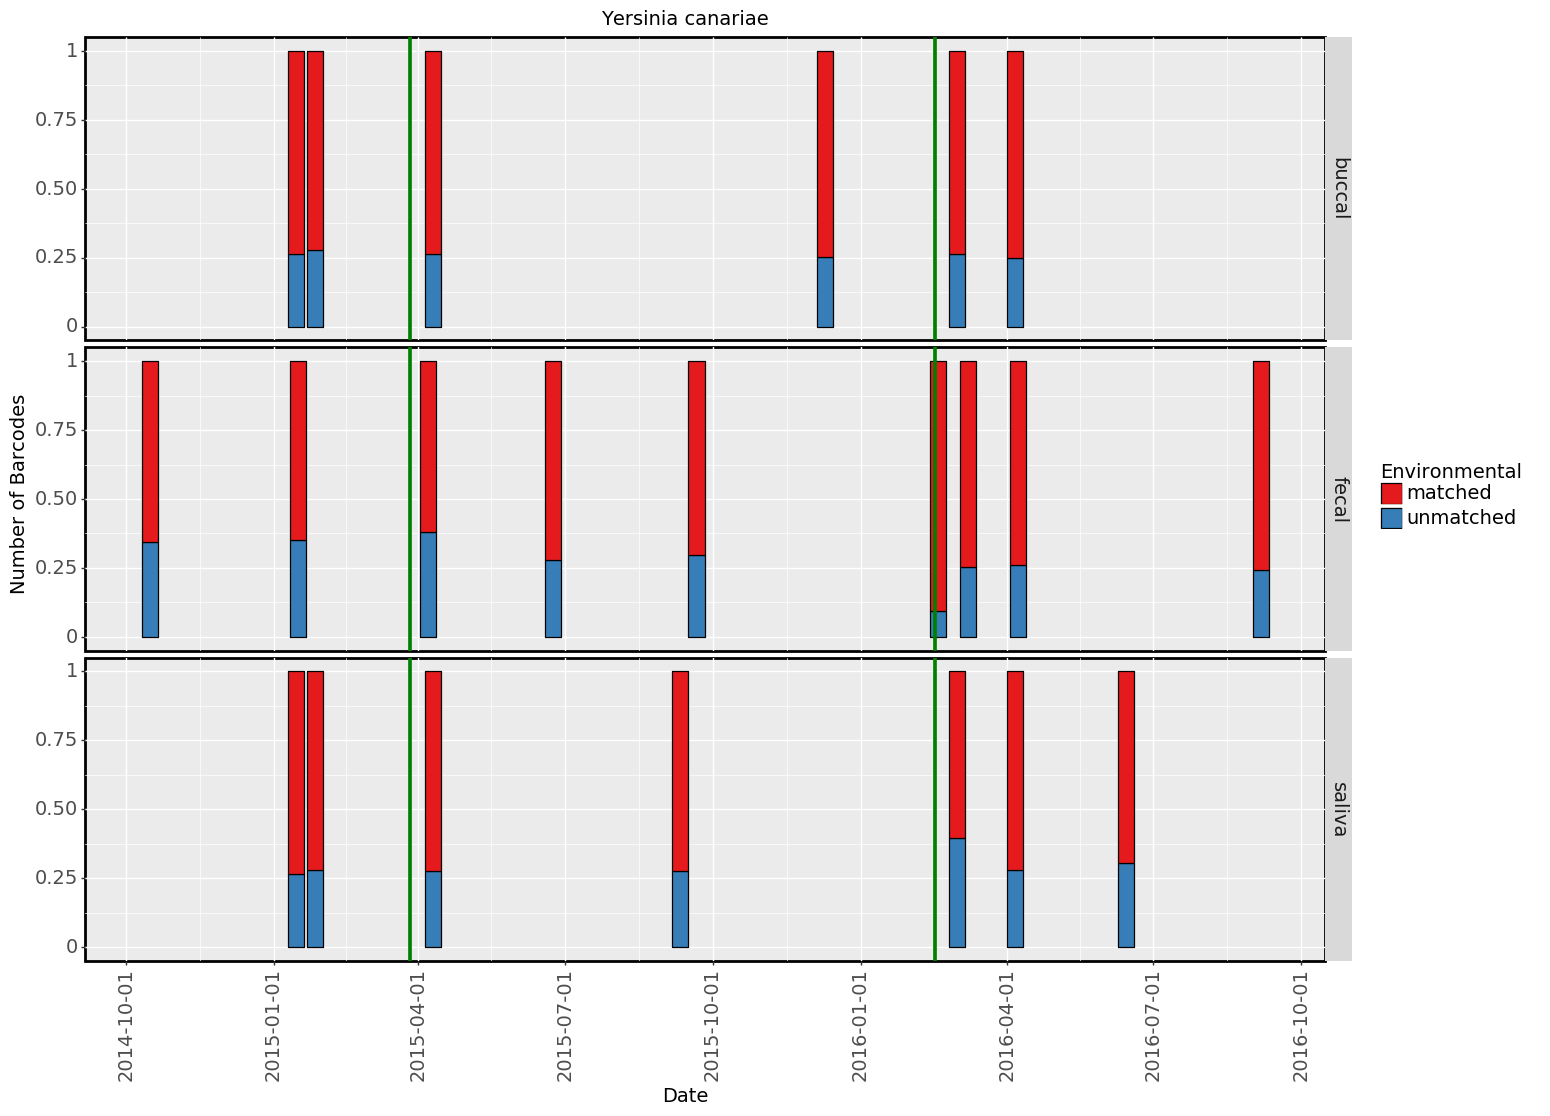

<ggplot: (8774701106310)>

In [80]:
(
    ggplot(tbl, aes(x='date', y='value', fill='variable')) +
        geom_col(width=10, color='black', position='fill') +
        facet_grid('kind~', scales='free') +
        scale_fill_brewer(type='qualitative', palette=6, direction=1) +
        xlab(f'Date') +
        ylab(f'Number of Barcodes') +
        labs(fill='Environmental') +
        ggtitle('Yersinia canariae') +
        geom_vline(xintercept='2015-03-27', color='green', size=1.5) +
        geom_vline(xintercept='2016-02-16', color='green', size=1.5) +
        theme(
            text=element_text(size=14),
            axis_text_x=element_text(angle=90),
            legend_position='right',
            panel_border=element_rect(colour="black", fill='none', size=2),
            figure_size=(16, 12),
        )
)